In [48]:
import ndjson
import json
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import cv2
import csv
import torch
import clip
from PIL import Image
from collections import deque
import datetime
import csv
from pathlib import Path
from ultralytics import YOLO
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, roc_curve, auc, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
)

In [20]:
# path of the labelbox metadata file
META_DATA_PATH = 'Metadata/Export  project - Fred-Labels - 7_16_2025.ndjson'

# directory to download the videos
VIDEOS_DIRECTORY = r"videos"

IMAGES_DIRECTORY = 'data/images'

EMBEDDINGS_DIRECTORY = 'data/image_embeddings'

CSV_PATH = 'car_state.csv'

YOLO_MODEL_PATH = r"E:\VS Code Folders\yolo_training\runs\yolo11l.pt_2025-07-01_epochs_80_val_0.08\weights\best.pt"


In [21]:
def check_path(video_path):
    if not os.path.exists(video_path):
        os.makedirs(video_path)
        print(f"Path {video_path} has been created successfully..!!")
    else:
        print(f"Path {video_path} already exists..!!")

In [22]:
check_path(VIDEOS_DIRECTORY)
check_path(IMAGES_DIRECTORY)
check_path(EMBEDDINGS_DIRECTORY)

Path videos already exists..!!
Path data/images already exists..!!
Path data/image_embeddings has been created successfully..!!


In [5]:
LABELS = ['offroad', 'onroad']

In [6]:
def download_video(video_url, video_name, video_path):
    """
    Downloads a video from the given URL and saves it with the specified name in the videos folder.
    
    Args:
        video_url (str): The URL of the video to be downloaded.
        video_name (str): The name of the video file.
        videos_folder (str): The path to the folder where the video will be saved.
    """
    if os.path.exists(video_path):
        print(f"Video '{video_path}' already exists. Skipping download.")
        return
    
    try:
        response = requests.get(video_url, stream=True)
        if response.status_code == 200:
            with open(video_path, 'wb') as file:
                for chunk in response.iter_content(chunk_size=1024):
                    file.write(chunk)
            print(f"Video '{video_name}' downloaded successfully.")
        else:
            print(f"Error downloading video '{video_name}': {response.status_code}")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading video '{video_name}': {e}")

In [7]:
def check_if_image_exists(path):
    if os.path.exists(path):
        print(f"Path: {path} already exists..!!")
        return True

In [8]:
def save_image(output_path, frame):
    if check_if_image_exists(output_path):
        print(f"Frame already exists at {output_path}")
        return False
    cv2.imwrite(output_path, frame)
    return True

In [9]:
def extract_frame_by_iteration(video_path, target_frame, output_path=None, save=False):
    if save and output_path and check_if_image_exists(output_path):
        print(f"Frame already exists at {output_path}")
        return cv2.imread(output_path)
    
    video = cv2.VideoCapture(video_path)
    if not video.isOpened():
        print("Error: Could not open video.")
        return None
    
    frame_count = 0
    success = True

    while success and frame_count <= target_frame:
        success, frame = video.read()
        frame_count += 1

        if frame_count == target_frame:
            if save and output_path:
                save_image(output_path, frame)
                print(f"Frame {target_frame} extracted and saved successfully.")
            else:
                print(f"Frame {target_frame} extracted successfully.")
            break

    if frame_count != target_frame:
        print(f"Error: Could not extract frame {target_frame}.")
        frame = None

    video.release()
    return frame

# Test
# extract_frame_by_iteration('videos/test.mp4', 105, 'images/test_105.png', True)

In [10]:
def is_offroad(frame_idx, ranges):
    return any(start <= frame_idx <= end for start, end in ranges)

In [11]:
def run_yolo_on_frame(frame, model, conf_threshold=0.8):
    
    results = model(frame, verbose=False, classes=[0])[0]  # class 0 = car

    for box in results.boxes:
        if box.conf.item() > conf_threshold:
            return True  # At least one car detected

    return False  # No car detected above threshold


In [12]:
def load_yolo_model(path):
    """Load YOLO model from the specified path."""
    return YOLO(path, task='detect')

In [13]:
yolo_model = load_yolo_model(YOLO_MODEL_PATH)

In [14]:
# Check if file exists
file_exists = os.path.exists(CSV_PATH)
file_exists

True

In [15]:
# # Check if file exists
# file_exists = os.path.exists(CSV_PATH)

# with open(CSV_PATH, 'a', newline='') as csvfile:  # 'a' mode = append
#     writer = csv.writer(csvfile)
    
#     if not file_exists:
#         writer.writerow(["video", "image_label", "frame_number", "label"])  # Only write header if new file

#     with open(META_DATA_PATH, 'r') as file:
#         metadata = ndjson.load(file)

#         for item in metadata[80:81]:
#             video_url = item['data_row']['row_data']
#             video_name = item['data_row']['external_id']
#             video_path = os.path.join(VIDEOS_DIRECTORY, video_name)

#             frame_count = item['media_attributes']['frame_count']
#             project_key = next(iter(item.get("projects", {})), None)
#             if not project_key:
#                 continue

#             frames = item["projects"][project_key]["labels"][0]["annotations"]["frames"]

#             # 1. Collect all offroad frames
#             offroad_list = []
#             for frame_str, annotations in frames.items():
#                 if any(obj['value'] == 'offroad' for obj in annotations['classifications']):
#                     offroad_list.append(int(frame_str))
            
#             if offroad_list:
#                 continue

#             download_video(video_url, video_name, video_path)

#             offroad_list.sort()

#             # 2. Form offroad ranges
#             offroad_ranges = []
#             if len(offroad_list) % 2 == 0:
#                 for i in range(0, len(offroad_list), 2):
#                     start = offroad_list[i]
#                     end = offroad_list[i + 1]
#                     offroad_ranges.append((start, end))

#             # 3. Write offroad frames
#             for start, end in offroad_ranges:
#                 for frame_number in range(start, end + 1, 2):
#                     image_label = f"{IMAGES_DIRECTORY}/{video_name[:-4]}_{frame_number}_0.png"
#                     writer.writerow([video_name, image_label[12:], frame_number, 0])  # Label 0 = offroad
#                     extract_frame_by_iteration(video_path, frame_number, image_label, save=True)

#             # 4. Sample every 10th other frame
#             for frame_number in range(1, frame_count, 5):
#                 if is_offroad(frame_number, offroad_ranges):
#                     continue  # Already handled

#                 frame = extract_frame_by_iteration(video_path, frame_number)
#                 if frame is None:
#                     continue

#                 detections = run_yolo_on_frame(frame, yolo_model)
#                 if (detections):
#                     image_label = f"{IMAGES_DIRECTORY}/{video_name[:-4]}_{frame_number}_1.png"
#                     if save_image(image_label, frame):
#                         print(f"Frame {frame_number} saved successfully.")
#                     writer.writerow([video_name, image_label[12:], frame_number, 1])  # Label 1 = onroad

In [16]:
onroad_count = 0
offroad_count = 0

with open(CSV_PATH, 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        label = row['label'].strip()
        if label == '1':
            onroad_count += 1
        elif label == '0':
            offroad_count += 1

print(f"Onroad frames (label=1): {onroad_count}")
print(f"Offroad frames (label=0): {offroad_count}")

Onroad frames (label=1): 2266
Offroad frames (label=0): 2234


In [17]:
def load_clip_model():
    print("Loading OpenAI CLIP...")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-L/14@336px", device=device)
    model.eval()
    print(f"Model loaded on {device}.")
    return model, preprocess, device

In [18]:
clip_model, preprocess, device = load_clip_model()

Loading OpenAI CLIP...
Model loaded on cuda.


In [24]:
images = os.listdir(IMAGES_DIRECTORY)

for image_name in images:
    image_path = os.path.join(IMAGES_DIRECTORY, image_name)

    # Skip non-image files
    if not image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.webp')):
        continue

    # Load and preprocess image
    bgr_img = cv2.imread(image_path)
    if bgr_img is None:
        print(f"Warning: Failed to load {image_name}")
        continue

    pil_image = Image.fromarray(cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB))
    img_tensor = preprocess(pil_image).unsqueeze(0).to(device)

    # Encode image with CLIP
    with torch.no_grad():
        img_feat = clip_model.encode_image(img_tensor)
        img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)

    # Convert to numpy and save
    embedding = img_feat.squeeze(0).cpu().numpy()
    emb_path = os.path.join(EMBEDDINGS_DIRECTORY, os.path.splitext(image_name)[0] + ".npy")
    np.save(emb_path, embedding)
    

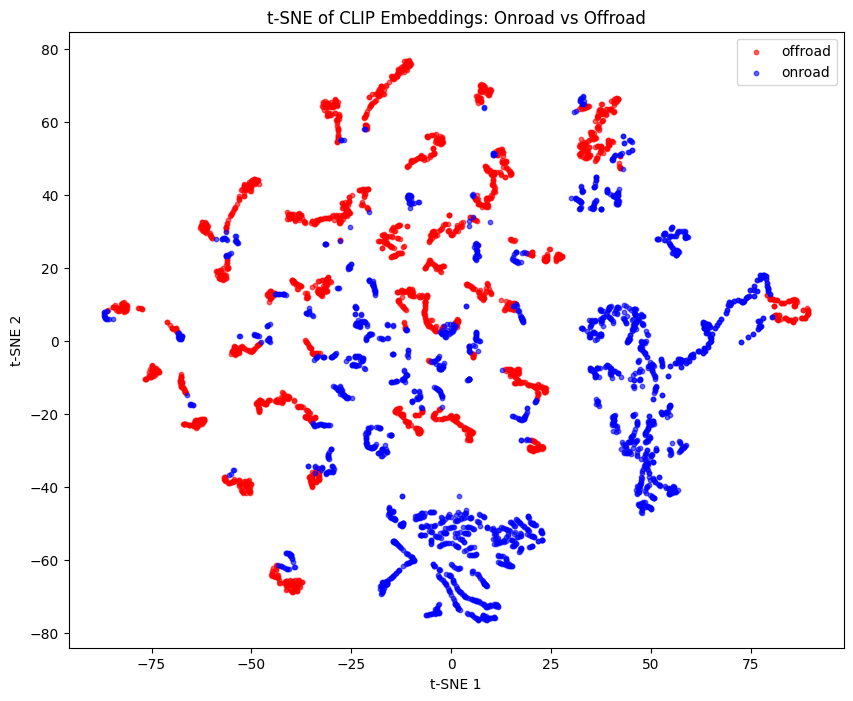

In [ ]:
embeddings = []
labels = []
label_names = []

with open(CSV_PATH, 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        image_name = row['image_label']
        label = int(row['label'])
        embedding_file = os.path.splitext(image_name)[0] + '.npy'
        embedding_path = os.path.join(EMBEDDINGS_DIRECTORY, embedding_file)
        if os.path.exists(embedding_path):
            emb = np.load(embedding_path)
            embeddings.append(emb)
            labels.append(label)
            label_names.append(image_name)
        else:
            print(f"Missing embedding for {embedding_path}")

embeddings = np.array(embeddings)
labels = np.array(labels)

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
colors = ['red', 'blue']
for label_value, color, label_str in zip([0, 1], colors, LABELS):
    idx = labels == label_value
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], c=color, label=label_str, alpha=0.6, s=10)

plt.legend()
plt.title('t-SNE of CLIP Embeddings: Onroad vs Offroad')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

In [ ]:
# 1. Read CSV and group by video
video_to_rows = {}
with open(CSV_PATH, 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        video = row['video']
        if video not in video_to_rows:
            video_to_rows[video] = []
        video_to_rows[video].append(row)

In [40]:
# 2. Split videos into train/val
videos = list(video_to_rows.keys())
train_videos, val_videos = train_test_split(videos, test_size=0.1, random_state=42)
print(f"Train videos: {len(train_videos)}")
print(f"Validation videos: {len(val_videos)}")

Train videos: 66
Validation videos: 8


In [41]:
def load_data(video_list):
    X, y = [], []
    for video in video_list:
        for row in video_to_rows[video]:
            image_name = row['image_label']
            label = int(row['label'])
            embedding_file = os.path.splitext(image_name)[0] + '.npy'
            embedding_path = os.path.join(EMBEDDINGS_DIRECTORY, embedding_file)
            if os.path.exists(embedding_path):
                emb = np.load(embedding_path)
                X.append(emb)
                y.append(label)
    return np.array(X), np.array(y)

In [42]:
# 3. Load embeddings and labels
X_train, y_train = load_data(train_videos)
X_val, y_val = load_data(val_videos)

print(f"Train samples: {len(y_train)}, Val samples: {len(y_val)}")

Train samples: 3967, Val samples: 535


In [46]:
# 4. Train a binary classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [47]:
# 5. Evaluate
y_pred = clf.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred, target_names=['offroad', 'onroad']))

Validation Accuracy: 0.930841121495327
              precision    recall  f1-score   support

     offroad       0.96      0.93      0.95       360
      onroad       0.87      0.93      0.90       175

    accuracy                           0.93       535
   macro avg       0.92      0.93      0.92       535
weighted avg       0.93      0.93      0.93       535




Training Logistic Regression...
Validation Accuracy: 0.9308
              precision    recall  f1-score   support

     offroad       0.96      0.93      0.95       360
      onroad       0.87      0.93      0.90       175

    accuracy                           0.93       535
   macro avg       0.92      0.93      0.92       535
weighted avg       0.93      0.93      0.93       535



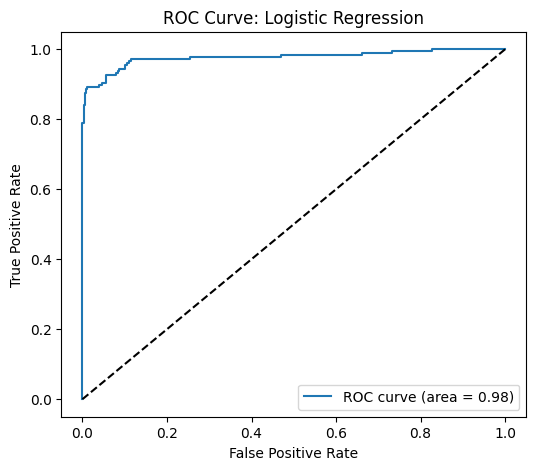

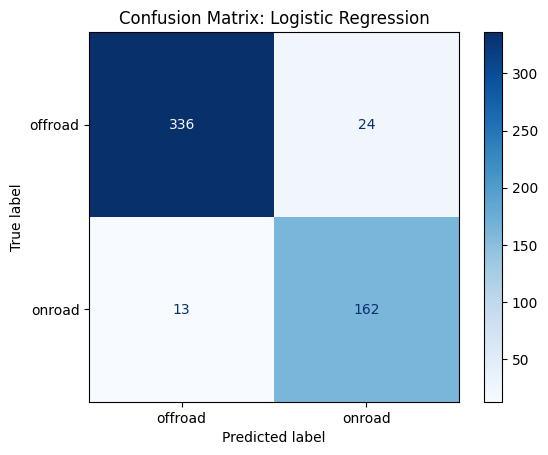


Training Linear SVM...
Validation Accuracy: 0.9252
              precision    recall  f1-score   support

     offroad       0.97      0.92      0.94       360
      onroad       0.85      0.94      0.89       175

    accuracy                           0.93       535
   macro avg       0.91      0.93      0.92       535
weighted avg       0.93      0.93      0.93       535



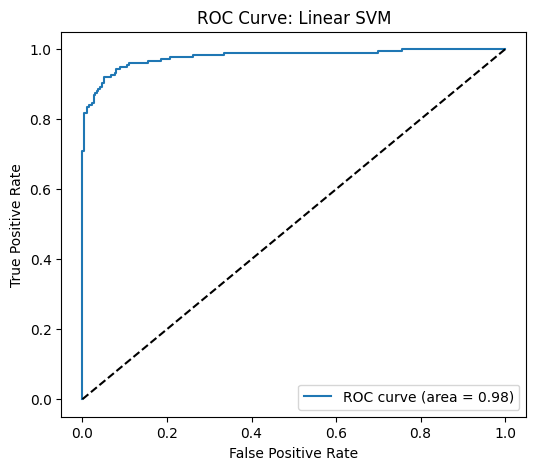

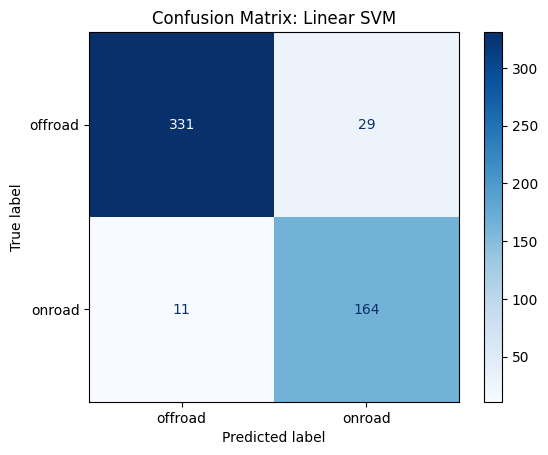


Training Kernel SVM (RBF)...
Validation Accuracy: 0.9383
              precision    recall  f1-score   support

     offroad       0.98      0.93      0.95       360
      onroad       0.87      0.95      0.91       175

    accuracy                           0.94       535
   macro avg       0.92      0.94      0.93       535
weighted avg       0.94      0.94      0.94       535



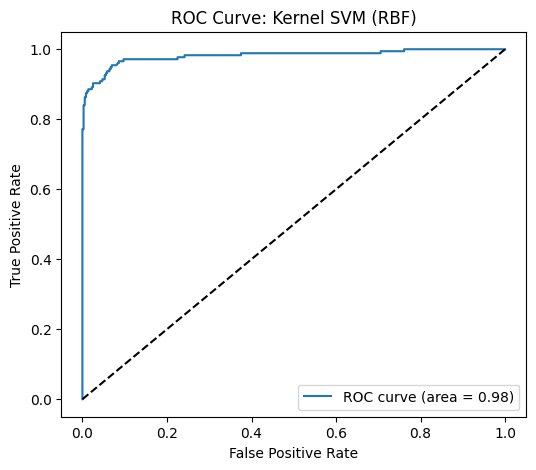

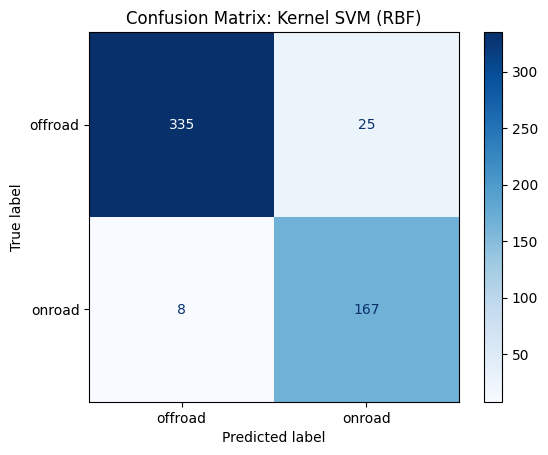


Training Random Forest...
Validation Accuracy: 0.8953
              precision    recall  f1-score   support

     offroad       0.99      0.86      0.92       360
      onroad       0.77      0.98      0.86       175

    accuracy                           0.90       535
   macro avg       0.88      0.92      0.89       535
weighted avg       0.92      0.90      0.90       535



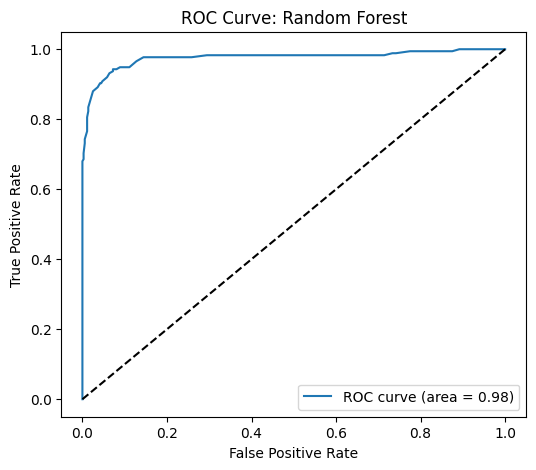

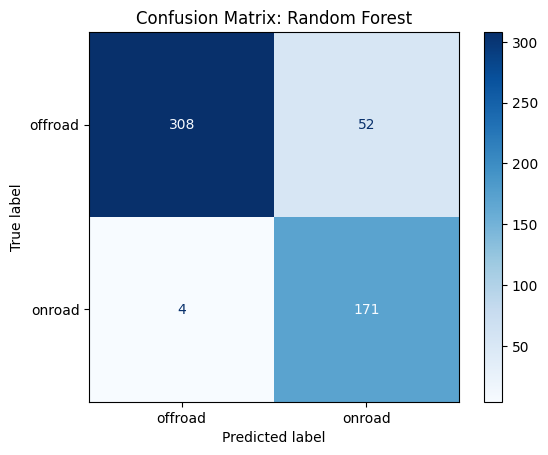


Training Gradient Boosting...
Validation Accuracy: 0.9121
              precision    recall  f1-score   support

     offroad       0.98      0.89      0.93       360
      onroad       0.81      0.95      0.88       175

    accuracy                           0.91       535
   macro avg       0.89      0.92      0.90       535
weighted avg       0.92      0.91      0.91       535



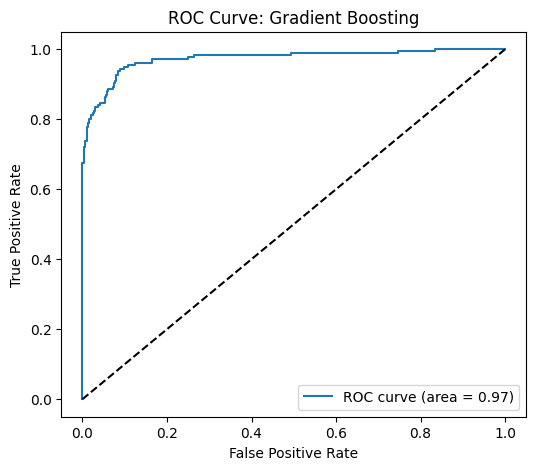

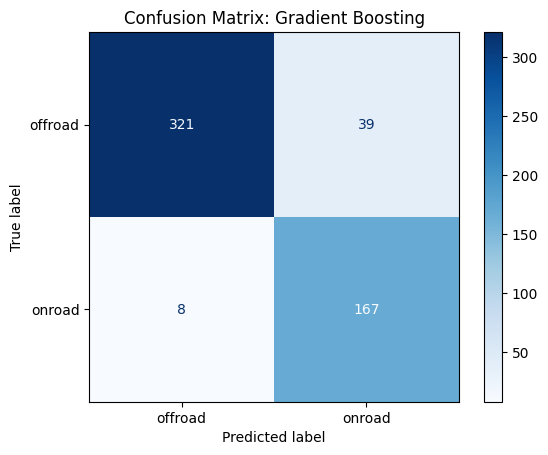


Training K-Nearest Neighbors...
Validation Accuracy: 0.9383
              precision    recall  f1-score   support

     offroad       0.94      0.97      0.95       360
      onroad       0.93      0.88      0.90       175

    accuracy                           0.94       535
   macro avg       0.94      0.92      0.93       535
weighted avg       0.94      0.94      0.94       535



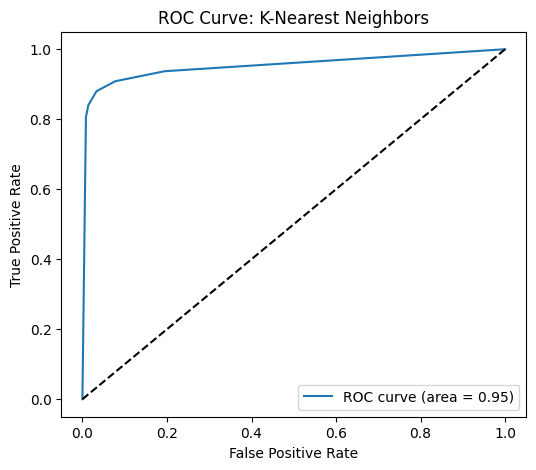

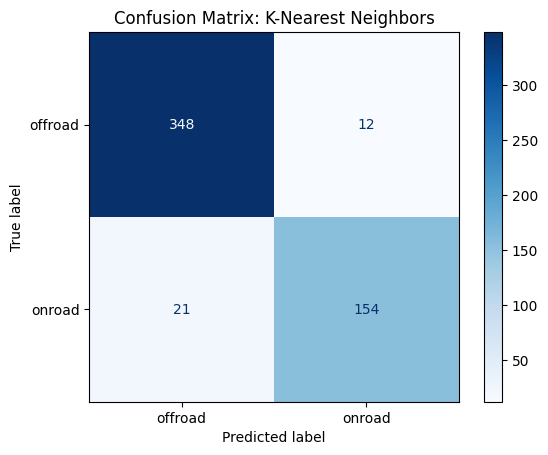


Summary of Validation Accuracies:
Logistic Regression: 0.9308
Linear SVM: 0.9252
Kernel SVM (RBF): 0.9383
Random Forest: 0.8953
Gradient Boosting: 0.9121
K-Nearest Neighbors: 0.9383


In [49]:
# Define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC(max_iter=10000),
    "Kernel SVM (RBF)": SVC(kernel='rbf', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
}

results = {}

for name, clf in classifiers.items():
    print(f"\nTraining {name}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    print(classification_report(y_val, y_pred, target_names=['offroad', 'onroad']))
    results[name] = acc

    # ROC Curve
    plt.figure(figsize=(6, 5))
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_val)[:, 1]
    else:
        # For LinearSVC, use decision_function
        y_score = clf.decision_function(X_val)
    fpr, tpr, _ = roc_curve(y_val, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {name}')
    plt.legend(loc="lower right")
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['offroad', 'onroad'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix: {name}')
    plt.show()


# Print summary
print("\nSummary of Validation Accuracies:")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")

Zero-Shot CLIP Classifier Results:
Validation Accuracy: 0.9009345794392524
              precision    recall  f1-score   support

     offroad       0.96      0.89      0.92       360
      onroad       0.80      0.93      0.86       175

    accuracy                           0.90       535
   macro avg       0.88      0.91      0.89       535
weighted avg       0.91      0.90      0.90       535



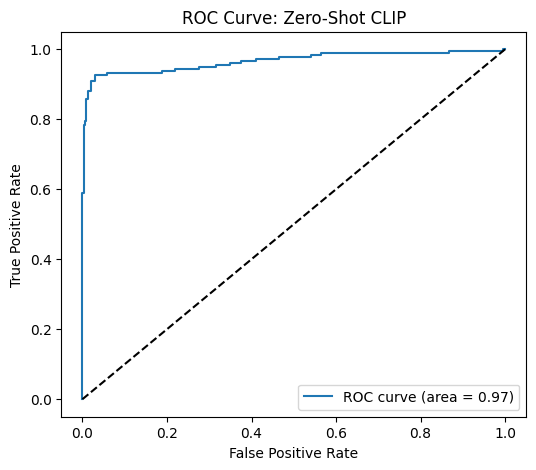

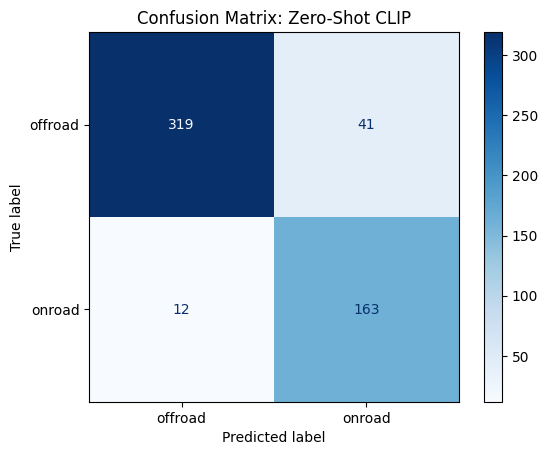

In [51]:
ON_ROAD_PROMPTS = [
    "A rally car racing on a designated rally stage",
    "A rally car at high speed on a tarmac race track",
    "A rally car drifting on a gravel track through a forest",
    "A rally car navigating a snowy mountain race course",
    "A photo of a rally car competing on the intended road",
    "A rally car under control on a wet and muddy path",
    'A photo of a rally car driving on a country side road',
    'A photo of a rally car driving on a road between green fields',
    'A photo of a rally car driving very fast on road',
    'A photo of a rally car driving very quickly on road with motion blur in the background',
    'A photo of a rally car on the road',
    'A rally car driving on a road',
]
OFF_ROAD_PROMPTS = [
    "A rally car that has crashed or spun off the road",
    "A rally car that has gone into a field or a ditch",
    "A rally car hitting a tree off the side of the track",
    "A photo of a rally car accident during a race",
    "A car that has lost control and left the designated race course",
    "A rally car stuck in the mud after leaving the track",
    'A photo of a car on the side of the road',
    'A photo of a car in the field',
    'A photo of a car in the ditch',
    'A photo of a car in greenery'
]
all_prompts = ON_ROAD_PROMPTS + OFF_ROAD_PROMPTS
on_road_count = len(ON_ROAD_PROMPTS)

# 2. Encode text prompts
with torch.no_grad():
    text_tokens = clip.tokenize(all_prompts).to(device)
    text_features = clip_model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_features = text_features.float()

# 3. Classify each validation embedding
y_pred_zeroshot = []
y_score_zeroshot = []

for emb in X_val:
    img_feat = torch.tensor(emb, dtype=torch.float32, device=device).unsqueeze(0)
    img_feat /= img_feat.norm(dim=-1, keepdim=True)
    with torch.no_grad():
        logits = 100.0 * img_feat @ text_features.T
        probs = logits.softmax(dim=-1).cpu().numpy()[0]
    prob_on = probs[:on_road_count].sum()
    prob_off = probs[on_road_count:].sum()
    y_pred_zeroshot.append(1 if prob_on > prob_off else 0)
    y_score_zeroshot.append(prob_on)  # Use prob_on as the "score" for ROC

y_pred_zeroshot = np.array(y_pred_zeroshot)
y_score_zeroshot = np.array(y_score_zeroshot)

# 4. Print metrics
print("Zero-Shot CLIP Classifier Results:")
print("Validation Accuracy:", accuracy_score(y_val, y_pred_zeroshot))
print(classification_report(y_val, y_pred_zeroshot, target_names=['offroad', 'onroad']))

# 5. ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_score_zeroshot)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Zero-Shot CLIP')
plt.legend(loc="lower right")
plt.show()

# 6. Confusion Matrix
cm = confusion_matrix(y_val, y_pred_zeroshot)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['offroad', 'onroad'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: Zero-Shot CLIP')
plt.show()

In [ ]:
print(len(y_pred_zeroshot))

535
